Reporte de clasificación:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3

Matriz de confusión:
[[0 0]
 [0 3]]


C:\Users\jeral\AppData\Local\Temp\ipykernel_12500\809336835.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['Baja', 'Sube'])
C:\Users\jeral\AppData\Local\Temp\ipykernel_12500\809336835.py:98: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ['Baja', 'Sube'])


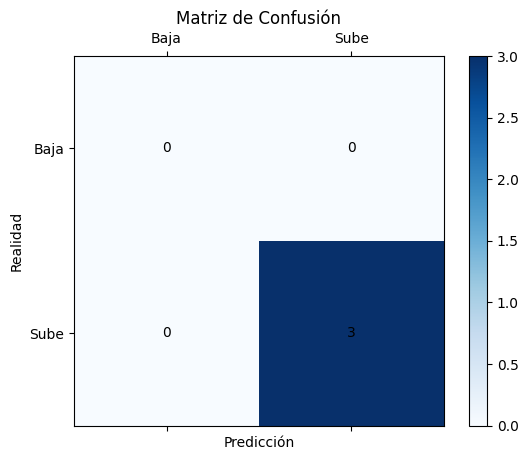

In [49]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import logging

# Configuración de logging
logging.basicConfig(
    filename="audit_log.txt",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

# Cargar los datos desde el archivo CSV
df = pd.read_csv("datos_cripto.csv")

# Preprocesamiento de los datos
# Convertir columnas de texto a string (si es necesario)
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype(str)

# Eliminar duplicados
df = df.drop_duplicates()

# Eliminar filas con valores nulos en columnas clave
df = df.dropna(subset=['nombre', 'simbolo', 'precio_usd'])

# Crear una columna de target para clasificación (sube o baja el precio)
# Usamos "cambio_24h" para predecir si el precio sube o baja
df['target'] = np.where(df['cambio_24h'] > 0, 1, 0)  # 1 si sube, 0 si baja

# Seleccionar las características (features) y el objetivo (target)
X = df[["precio_usd", "cambio_24h", "capitalizacion_mercado"]]  # Características
y = df['target']  # Objetivo

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Estandarizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Entrenamiento del modelo SVM
def train_svm(X_train, y_train):
    # Crear el modelo SVM
    svm_model = SVC(kernel='linear', random_state=42)

    # Entrenar el modelo
    svm_model.fit(X_train, y_train)

    return svm_model

def predict_price(price_usd, change_24h, market_cap):
    # Validación de datos de entrada
    if price_usd <= 0 or market_cap <= 0 or change_24h < -100 or change_24h > 100:
        return "Datos de entrada no válidos. Asegúrese de ingresar valores correctos."

    # Preprocesar la entrada
    input_data = np.array([[price_usd, change_24h, market_cap]])

    # Estandarizar los datos antes de predecir
    input_data_scaled = scaler.transform(input_data)

    # Hacer la predicción
    prediction = svm_model.predict(input_data_scaled)

    if prediction == 1:
        return "El precio de la criptomoneda subirá."
    else:
        return "El precio de la criptomoneda bajará."


# Evaluación del modelo
def evaluate_model(svm_model, X_test, y_test):
    y_pred = svm_model.predict(X_test)
    
    # Reporte de clasificación
    print("Reporte de clasificación:")
    print(classification_report(y_test, y_pred))
    
    # Matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])  # Especificamos las clases 0 y 1
    print("Matriz de confusión:")
    print(conf_matrix)
    
    # Graficar la matriz de confusión usando matplotlib
    fig, ax = plt.subplots()
    cax = ax.matshow(conf_matrix, cmap='Blues')
    fig.colorbar(cax)

    # Añadir etiquetas
    ax.set_xticklabels([''] + ['Baja', 'Sube'])
    ax.set_yticklabels([''] + ['Baja', 'Sube'])

    # Añadir texto de los valores
    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, f'{val}', ha='center', va='center', color='black')

    plt.title("Matriz de Confusión")
    plt.xlabel('Predicción')
    plt.ylabel('Realidad')
    plt.show()


# Main
if __name__ == "__main__":
    try:
        # Entrenar el modelo SVM
        svm_model = train_svm(X_train, y_train)

        # Evaluar el modelo
        evaluate_model(svm_model, X_test, y_test)

    except Exception as e:
        logging.error(f"Error en el pipeline: {e}")
        print(f"Error en el pipeline: {e}")

   

In [50]:
import joblib
joblib.dump(svm_model, "svm_model.pkl")

['svm_model.pkl']